In [2]:
!choco install miktex


'choco' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
! sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app


In [55]:
#Misbahul Amin

import numpy as np 
import pandas as pd 
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input,decode_predictions
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.layers import Concatenate
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Any results you write to the current directory are saved as output.

In [56]:
InputPath = './lol_dataset/our485/low/'

In [62]:
def noisy(noise_typ, image):
    if noise_typ == "gauss":
        row, col, ch = image.shape
        mean = 0
        var = 0.01  # Variance
        sigma = var**0.5  # Standard deviation
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row, col, ch)
        noisy = image + gauss
        return np.clip(noisy, 0, 1)  # Ensure pixel values are in [0, 1]

    elif noise_typ == "s&p":
        row, col, ch = image.shape
        s_vs_p = 0.5
        amount = 0.05  # Amount of noise
        out = np.copy(image)

        # Salt mode
        num_salt = int(np.ceil(amount * image.size * s_vs_p))
        coords = [np.random.randint(0, i, num_salt) for i in image.shape[:2]]
        out[tuple(coords)] = 1  # White pixels

        # Pepper mode
        num_pepper = int(np.ceil(amount * image.size * (1. - s_vs_p)))
        coords = [np.random.randint(0, i, num_pepper) for i in image.shape[:2]]
        out[tuple(coords)] = 0  # Black pixels

        return out

    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return np.clip(noisy, 0, 1)  # Ensure pixel values are in [0, 1]

    elif noise_typ == "speckle":
        row, col, ch = image.shape
        gauss = np.random.randn(row, col, ch)
        gauss = gauss.reshape(row, col, ch)
        noisy = image + image * gauss
        return np.clip(noisy, 0, 1)  # Ensure pixel values are in [0, 1]

    else:
        raise ValueError(f"Unsupported noise type: {noise_typ}")


np.uint8(117)

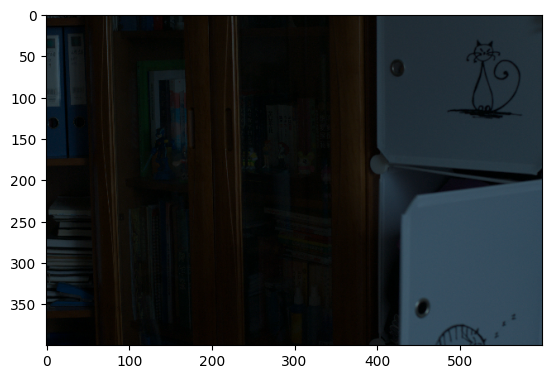

In [63]:
img = cv.imread(InputPath+"2.png")  
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.imshow(img)
l

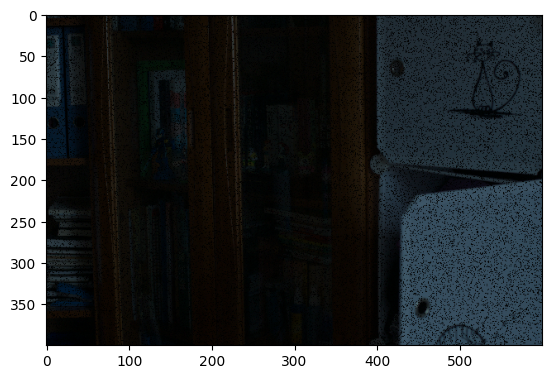

In [64]:
Noise = noisy("s&p",img)
plt.imshow(Noise)

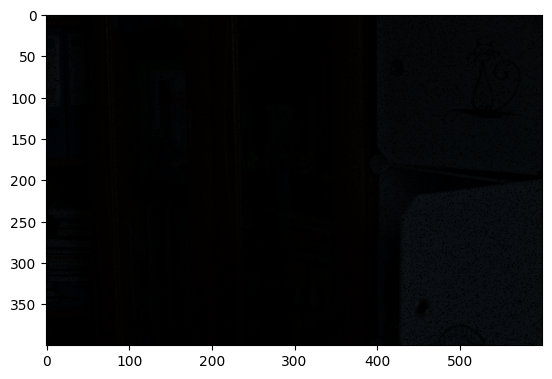

In [65]:
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV) #convert it to hsv
hsv[...,2] = hsv[...,2]*0.2
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
Noise2 = noisy("s&p",img1)

plt.imshow(Noise2)

In [66]:
def PreProcessData(ImagePath):
    X_=[]
    y_=[]
    count=0
    for imageDir in os.listdir(ImagePath):
        if count<2131:
            try:
                count=count+1
                img = cv.imread(ImagePath + imageDir)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img_y = cv.resize(img,(500,500))
                hsv = cv.cvtColor(img_y, cv.COLOR_BGR2HSV) #convert it to hsv
                hsv[...,2] = hsv[...,2]*0.2
                img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
                Noisey_img = noisy("s&p",img_1)
                X_.append(Noisey_img)
                y_.append(img_y)
            except:
                pass
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_,y_

In [67]:
X_,y_ = PreProcessData(InputPath)

In [68]:
K.clear_session()
def InstantiateModel(in_):
    
    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)
    
    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)
    
    model_add = add([model_1,model_2,model_2_0])
    
    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)
    
    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)
    
    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)
    
    model_add_2 = add([model_3_1,model_3_2,model_3])
    
    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)
    #Extension
    model_add_3 = add([model_4_1,model_add_2,model_4])
    
    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)
    
    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)
    
    return model_5
    

In [69]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)

In [70]:
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 500, 500, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 500, 500, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 500, 500, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 500, 500, 32)      │           4,640 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 500, 500, 64)      │           8,256 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 500, 500, 64)      │           8,256 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 500, 500, 64)      │          16,448 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 500, 500, 64)      │               0 │ conv2d_2[0][0],            │
│                               │                           │                 │ conv2d_4[0][0],            │
│                               │                           │                 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 500, 500, 64)      │          36,928 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 500, 500, 32)      │          18,464 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 500, 500, 32)      │          18,464 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 500, 500, 16)      │           2,064 │ conv2d_9[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 500, 500, 16)      │           4,112 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 500, 500, 16)      │           2,064 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 500, 500, 16)      │               0 │ conv2d_10[0][0],           │
│                               │                           │                 │ conv2d_11[0][0],           │
│                               │                           │                 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 134,067 (523.70 KB)

 Trainable params: 134,067 (523.70 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
"""
from tensorflow.keras.utils import plot_model
plot_model(Model_Enhancer, to_file='model1_.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image(retina=True, filename='model1_.png')
"""

"\nfrom tensorflow.keras.utils import plot_model\nplot_model(Model_Enhancer, to_file='model1_.png', show_shapes=True, show_layer_names=True)\n\nfrom IPython.display import Image\nImage(retina=True, filename='model1_.png')\n"

In [78]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_Enhancer.fit(GenerateInputs(X_, y_), epochs=53, verbose=1, steps_per_epoch=39, shuffle=True)

Epoch 1/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 163.9766
Epoch 2/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 18.7183
Epoch 3/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 937ms/step - loss: 21.3579
Epoch 4/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 38.6740
Epoch 5/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 953ms/step - loss: 95.5234
Epoch 6/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 31.0819
Epoch 7/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 917ms/step - loss: 10.5080
Epoch 8/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 833ms/step - loss: 31.2549
Epoch 9/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 820ms/step - loss: 14.1511
Epoch 10/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 826ms/step - loss: 12.7887
Epoch 11/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 815ms/step - loss: 14.5392
Epoch 12/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 829ms/step - loss: 10.8400
Epoch 13/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - loss: 5.8854
Epoch 14/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.7730  
Epoch 15/53
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [100]:
TestPath= './lol_dataset/our485/high/'

In [101]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(500,500))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV) #convert it to hsv
    hsv[...,2] = hsv[...,2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = noisy("s&p",img1)
    Noise = Noise.reshape(1,500,500,3)
    return Noise

In [103]:
ImagePath=TestPath+"5.png"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


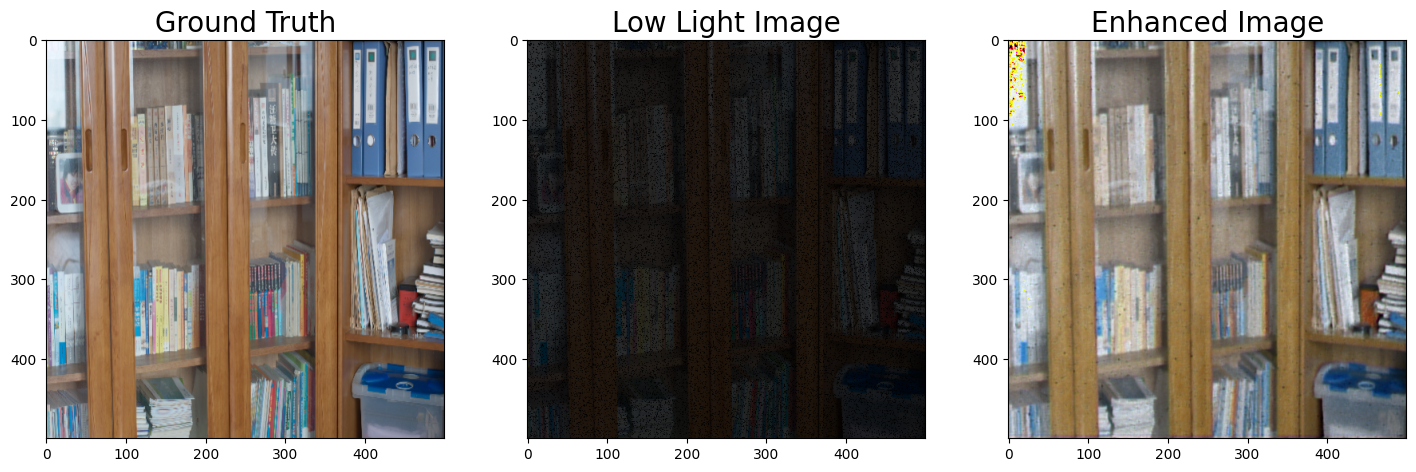

In [105]:
Image_test=TestPath+"5.png"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)


In [106]:
ImagePath=TestPath+"21.png"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


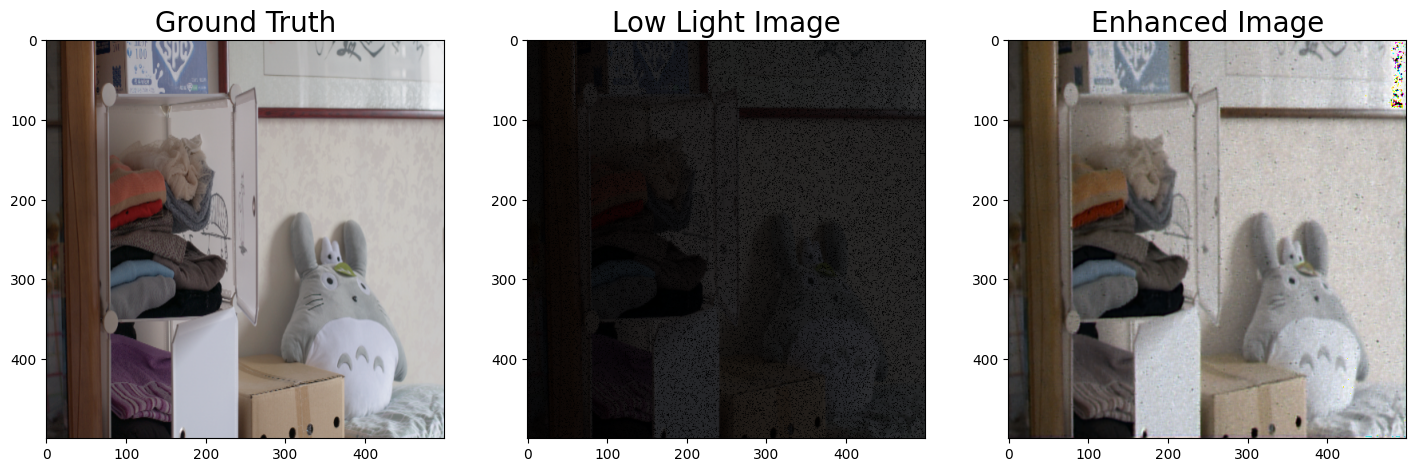

In [107]:
Image_test=TestPath+"21.png"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

In [111]:
ImagePath=TestPath+"58.png"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


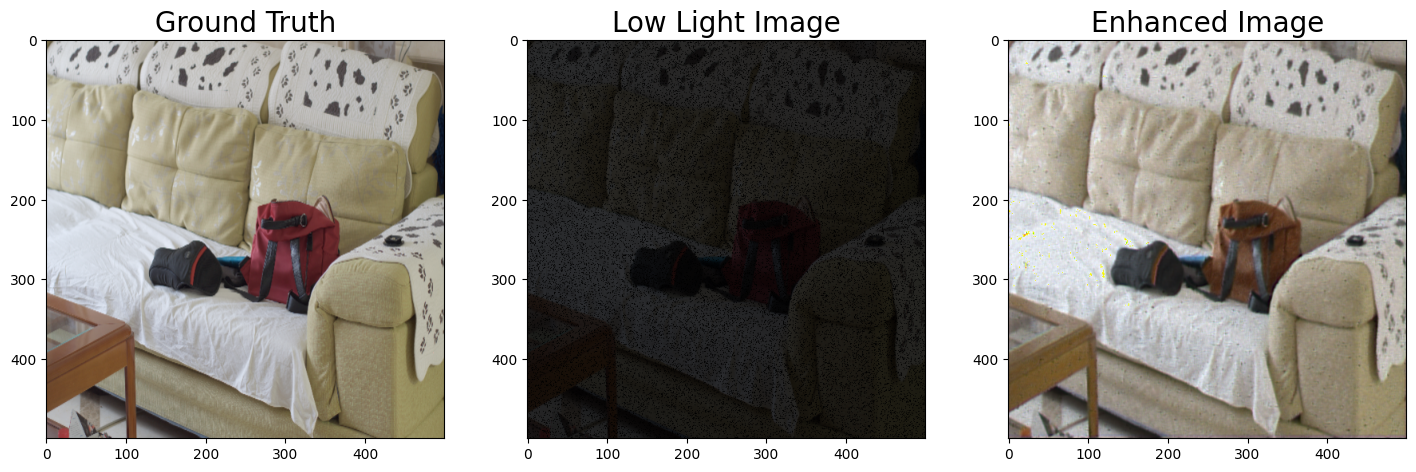

In [112]:
Image_test=TestPath+"58.png"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

In [113]:
ImagePath=TestPath+"50.png"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


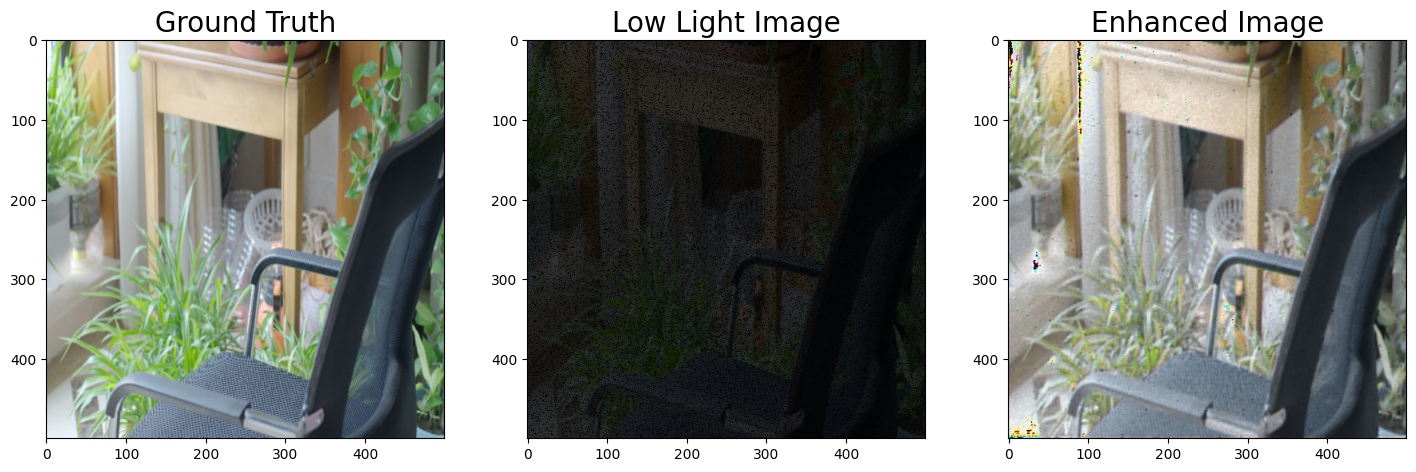

In [114]:
Image_test=TestPath+"50.png"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(Image_test)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(Image_test)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)